<a href="https://colab.research.google.com/github/yanli499/ChatTime/blob/master/Text_Sentiment_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchtext

# The first time you run this will download a ~823MB file
glove = torchtext.vocab.GloVe(name="twitter.27B", # trained on Twitter 2014 corpus
                              dim=200)   # embedding size = 50

In [30]:
#setup Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#get text data 
#split text data 

import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
import numpy as np
import matplotlib.pyplot as plt

# file location (make sure to use your file location)
#file_dir = '/content/drive/My Drive/Colab Notebooks/aps360/Projects/'
file_dir = '/content/drive/My Drive/Colab Notebooks/'

def get_data():
    return csv.reader(open(file_dir + "parsed_data.csv"))

def split_tweet(tweet,print_data):
    # separate punctuations
    
    tweet = tweet.replace(".", " . ") \
                 .replace(",", " , ") \
                 .replace(";", " ; ") \
                 .replace("?", " ? ")   

    if(print_data < 2):
      print("Original Data: ")
      print(tweet)
      print("Split and Normalized Data: ")
      print(tweet.lower().split())
    return tweet.lower().split()

In [0]:
#convert to pandas for baseline model
import pandas as pd

columns = ['label', 'text']
df_train = pd.DataFrame(columns=columns)
df_val = pd.DataFrame(columns=columns)
df_test = pd.DataFrame(columns=columns)

In [33]:
#split the sentence to words and distribute it into train, test, validation equally 
def get_tweet_words(glove_vector):
    print_data = 0
    train, valid, test = [], [], []
    tr,vl,te = 0,0,0
    num_pos, num_neg = 0, 0
    pos_train,neg_train, pos_val,neg_val, pos_test,neg_test = 0,0,0,0,0,0
    for i, line in enumerate(get_data()):
        if i % 1 == 0:
            tweet = line[-1]
            #print(tweet)
            idxs = [glove_vector.stoi[w]        # lookup the index of word
                    for w in split_tweet(tweet,print_data)
                    if w in glove_vector.stoi] # keep words that has an embedding
            if not idxs: # ignore tweets without any word with an embedding
                continue
            
            if (print_data < 2):
              print("Glove indexed data: ")
              print(idxs)

            idxs = torch.tensor(idxs) # convert list to pytorch tensor 

            if (print_data < 2):
              print("Tensor data: ")
              print(idxs)

            print_data +=1 
            if (line[0] == '0'):
              label = torch.tensor(int(1)).long()
            else:
              label = torch.tensor(int(0)).long() 

            label_panda = 'sdf'
            if (label.item() == 0):# create labels for panda dataset
                label_panda = 'neg'
                num_neg +=1
            elif(label.item() == 1):
                label_panda = 'pos'
                num_pos +=1

            if i % 5 < 3:
                s1 = [tweet, label.item()] 
                #insert the data in panda train dataset
                df_train.loc[tr, 'text'] = tweet 
                df_train.loc[tr, 'label'] = label_panda 
                tr+=1
                train.append((idxs, label))

                if(label == 1):
                  pos_train +=1

                elif(label == 0): 
                  neg_train +=1

            elif i % 5 == 4:
               #insert the data in panda validation dataset
                s1 = [tweet, label.item()]
                df_val.loc[vl, 'text'] = tweet
                df_val.loc[vl, 'label'] = label_panda           
                vl+=1          
                valid.append((idxs, label))

                if(label == 1):
                  pos_val +=1

                elif(label == 0): 
                  neg_val +=1                
            else:
               #insert the data in panda test dataset
                s1 = [tweet, label.item()]
                df_test.loc[te, 'text'] = tweet
                df_test.loc[te, 'label'] = label_panda
                te+=1           
                test.append((idxs, label))
                if(label == 1):
                  pos_test +=1

                elif(label == 0): 
                  neg_test +=1

    print("num pos = " + str(num_pos))    
    print("num neg = " + str(num_neg))  

    print("num pos train = " + str(pos_train))    
    print("num neg  train = " + str(neg_train))    

    print("num pos val = " + str(pos_val))    
    print("num neg  val = " + str(neg_val))    

    print("num pos test = " + str(pos_test))    
    print("num neg  test = " + str(neg_test))    

    return train, valid, test

train, valid, test = get_tweet_words(glove)


Original Data: 
Who is the biggest gossiper you know ? 
Split and Normalized Data: 
['who', 'is', 'the', 'biggest', 'gossiper', 'you', 'know', '?']
Glove indexed data: 
[127, 32, 13, 1971, 519588, 15, 115, 14]
Tensor data: 
tensor([   127,     32,     13,   1971, 519588,     15,    115,     14])
Original Data: 
Get fucking real dude . 
Split and Normalized Data: 
['get', 'fucking', 'real', 'dude', '.']
Glove indexed data: 
[87, 408, 312, 1052, 1]
Tensor data: 
tensor([  87,  408,  312, 1052,    1])
num pos = 12022
num neg = 7800
num pos train = 7211
num neg  train = 4681
num pos val = 2404
num neg  val = 1559
num pos test = 2407
num neg  test = 1560


In [34]:
print(len(train))
print(len(valid))
print(len(test))

11892
3963
3967


In [35]:
print(train[0])

(tensor([   127,     32,     13,   1971, 519588,     15,    115,     14]), tensor(1))


In [36]:
df_train[:3]

,label,text
0,pos,Who is the biggest gossiper you know?
1,neg,Get fucking real dude.
2,neg,She is as dirty as they come and that crook R...


In [0]:
class TweetRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TweetRNN, self).__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)#nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb(x)
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        c0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, (h0,c0))
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

In [0]:
class TweetRNN_GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TweetRNN_GRU, self).__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)#nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb(x)
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

In [0]:
import random
#referenced from tutorial 
class TweetBatcher:
    def __init__(self, tweets, batch_size=32, drop_last=False):
        # store tweets by length
        self.tweets_by_length = {}
        for words, label in tweets:
            # compute the length of the tweet
            wlen = words.shape[0]
            # put the tweet in the correct key inside self.tweet_by_length
            if wlen not in self.tweets_by_length:
                self.tweets_by_length[wlen] = []
            self.tweets_by_length[wlen].append((words, label),)
         
        #  create a DataLoader for each set of tweets of the same length
        self.loaders = {wlen : torch.utils.data.DataLoader(
                                    tweets,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    drop_last=drop_last) # omit last batch if smaller than batch_size
            for wlen, tweets in self.tweets_by_length.items()}
        
    def __iter__(self): # called by Python to create an iterator
        # make an iterator for every tweet length
        iters = [iter(loader) for loader in self.loaders.values()]
        while iters:
            # pick an iterator (a length)
            im = random.choice(iters)
            try:
                yield next(im)
            except StopIteration:
                # no more elements in the iterator, remove it
                iters.remove(im)

In [0]:
def get_accuracy(model, data_loader):
  #get accuracy from model 
    correct, total = 0, 0
    for tweets, labels in data_loader:
        output = model(tweets) 
        pred = output.max(1, keepdim=True)[1] 
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

In [0]:
def get_loss(model, data_loader, criterion):
  #get loss
    total_loss = 0.0
    for i, batch in enumerate(data_loader):
        tweets = batch[0]
        labels = batch[1]
        output = model(tweets)
        loss = criterion(output, labels)
        total_loss += loss.item()      
            
    loss = float(total_loss)/ (i + 1)
    return loss

In [0]:
def train_rnn_network(model, train, valid, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss() #the loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #the optimizer
    losses, train_acc, valid_acc, val_loss = [], [], [],[]
    epochs = []
    for epoch in range(num_epochs):
        i = 0
        for tweets, labels in train:
            optimizer.zero_grad() #setting the optimizer to zero
    
            pred = model(tweets) #get the prediction from the model

            loss = criterion(pred, labels) #calculate the loss based on the prediction
            loss.backward() #computes changes to weight
            optimizer.step() #optimization step
            i+=1


        losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_loader))
        valid_acc.append(get_accuracy(model, valid_loader))
        val_loss.append(get_loss(model, valid_loader, criterion))
        print("Epoch %d; Train Loss %f; Train Acc %f; Val Loss %f; Val Acc %f" % (
              epoch+1, losses[-1], train_acc[-1], val_loss[-1], valid_acc[-1]))
        

    # plotting
    plt.title("Training Curve")
    plt.plot(epochs, losses, label="Train")
    plt.plot(epochs, val_loss, label="Validation")    
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

Epoch 1; Train Loss 0.550462; Train Acc 0.706019; Val Loss 0.497306; Val Acc 0.694676
Epoch 2; Train Loss 0.670470; Train Acc 0.725825; Val Loss 0.625065; Val Acc 0.696442
Epoch 3; Train Loss 0.345928; Train Acc 0.774563; Val Loss 0.510584; Val Acc 0.725461
Epoch 4; Train Loss 0.409840; Train Acc 0.821359; Val Loss 0.478834; Val Acc 0.755741
Epoch 5; Train Loss 0.418378; Train Acc 0.889709; Val Loss 0.459111; Val Acc 0.787030
Epoch 6; Train Loss 0.239428; Train Acc 0.929417; Val Loss 0.466129; Val Acc 0.827656
Epoch 7; Train Loss 0.117940; Train Acc 0.957184; Val Loss 0.502575; Val Acc 0.840273


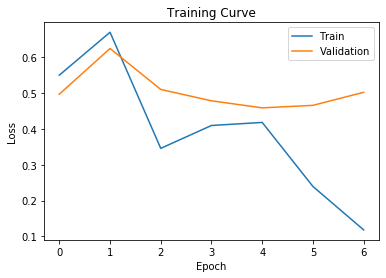

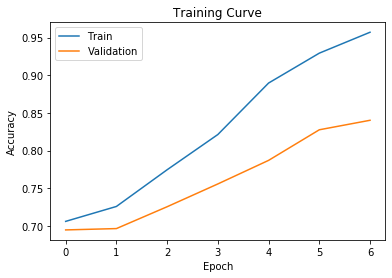

In [43]:
model = TweetRNN_GRU(200, 100, 2)#GRU optimal parameters
train_loader = TweetBatcher(train, batch_size=100, drop_last=True)
valid_loader = TweetBatcher(valid, batch_size=100, drop_last=False)
train_rnn_network(model, train_loader, valid_loader, num_epochs=7, learning_rate=0.003)

In [0]:
def get_new_tweet(glove_vector, sample_tweet):
    tweet = sample_tweet
    idxs = [glove_vector.stoi[w]        # lookup the index of word
            for w in split_tweet(tweet, 3)
            if w in glove_vector.stoi] # keep words that has an embedding
    idxs = torch.tensor(idxs) # convert list to pytorch tensor
    return idxs

In [45]:
new_tweet = get_new_tweet(glove, "Can you pleaaassseeeee give us a 100 on this course")

out = torch.sigmoid(model(new_tweet.unsqueeze(0)))
pred = out.max(1, keepdim=True)[1]
print(pred)

tensor([[1]])


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Create feature vectors
vectorizer = TfidfVectorizer(sublinear_tf = True,
                             use_idf = True)
train_vecti = vectorizer.fit_transform(df_train['text'])
test_vecti = vectorizer.transform(df_test['text'])

In [48]:
import time
from sklearn import svm
from sklearn.metrics import classification_report

#svm calculation
classifier_linear = svm.SVC(kernel='linear')
print(df_train['label'])
classifier_linear.fit(train_vecti, df_train['label'])
prediction_linear = classifier_linear.predict(test_vecti)

out_rep = classification_report(df_test['label'], prediction_linear, output_dict=True)
print('positive: ', out_rep['pos'])
print('negative: ', out_rep['neg'])

0        pos
1        neg
2        neg
3        neg
4        neg
        ... 
11887    pos
11888    pos
11889    pos
11890    pos
11891    pos
Name: label, Length: 11892, dtype: object
positive:  {'precision': 0.854416333777186, 'recall': 0.7997507270461155, 'f1-score': 0.8261802575107297, 'support': 2407}
negative:  {'precision': 0.7187864644107351, 'recall': 0.7897435897435897, 'f1-score': 0.752596212583995, 'support': 1560}


In [0]:
#lists for true negative and true positive creation
actual= []
predicted = []

In [0]:
#Test accuracy to save actual and predicted labels for the test dataset for confusion matrix calculations

def test_get_accuracy(model, data_loader):
    correct, total = 0, 0
    for tweets, labels in data_loader:
        output = model(tweets)
        pred = output.max(1, keepdim=True)[1]
        #print(pred.item())
        predicted.append(int(pred.item()))
        correct += pred.eq(labels.view_as(pred)).sum().item()
        #print(labels.item())
        actual.append(int(labels.item()))
        total += labels.shape[0]
    return correct / total

In [0]:

test_loader = TweetBatcher(test, batch_size=1, drop_last=False)


In [52]:
test_accuracy = test_get_accuracy(model, test_loader)
print(test_accuracy)


0.8479959667254853


In [0]:
 #change list to array for actual and predicted
actual = np.array(actual)
predicted = np.array(predicted)

           Bully  Non-Bully
Bully       1412        148
Non-Bully    455       1952


(2, 0)

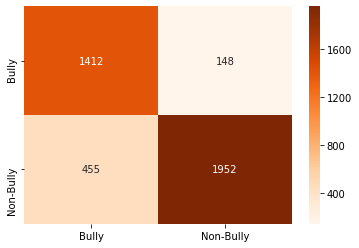

In [59]:
from pandas import DataFrame
import numpy as np
import seaborn as sea
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

col = ['Bully', 'Non-Bully']

fm = confusion_matrix(actual, predicted)
com = DataFrame(fm, index=col, columns=col)
print(com)

ax = sea.heatmap(com, cmap='Oranges', annot=True, fmt = 'g')
ax.set_ylim(len(com), 0)

In [0]:
actual_comb =  [[5,0,0,0,0,0,0,0,0,0], 
                [0,5,0,0,0,0,0,0,0,0], 
                [0,0,5,0,0,0,0,0,0,0], 
                [0,0,0,5,0,0,0,0,0,0], 
                [0,0,0,0,5,0,0,0,0,0], 
                [0,0,0,0,0,5,0,0,0,0], 
                [0,0,0,0,0,0,5,0,0,0], 
                [0,0,0,0,0,0,0,5,0,0], 
                [0,0,0,0,0,0,0,0,5,0],
                [0,0,0,0,0,0,0,0,0,5]]


predicted_comb = [[1,0,0,0,3,0,1,0,0,0], 
                  [0,1,0,0,0,3,0,1,0,0], 
                  [0,0,2,0,3,0,0,0,0,0], 
                  [0,0,0,2,0,3,0,0,0,0], 
                  [0,0,0,0,5,0,0,0,0,0], 
                  [0,0,0,0,0,5,0,0,0,0], 
                  [0,0,0,0,0,0,5,0,0,0], 
                  [0,0,0,0,0,0,0,5,0,0], 
                  [0,0,0,0,2,0,0,0,3,0],
                  [0,0,0,0,0,2,0,0,0,3]]

                           Happy - Bully  ...  Neutral - Non-Bully
Happy - Bully                          1  ...                    0
Happy - Non-Bully                      0  ...                    0
Sad - Bully                            0  ...                    0
Sad- Non-Bully                         0  ...                    0
Anger/Disgust - Bully                  0  ...                    0
Anger/Disgust - Non-Bully              0  ...                    0
Surprised - Bully                      0  ...                    0
Surprised - Non-Bully                  0  ...                    0
Neutral - Bully                        0  ...                    0
Neutral - Non-Bully                    0  ...                    3

[10 rows x 10 columns]


(10, 0)

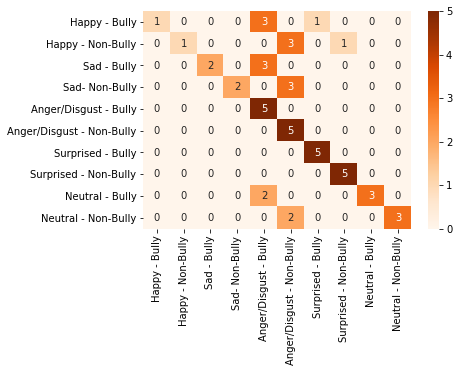

In [63]:
col = ['Happy - Bully', 'Happy - Non-Bully', 'Sad - Bully', 'Sad- Non-Bully', 'Anger/Disgust - Bully', 'Anger/Disgust - Non-Bully', 'Surprised - Bully', 'Surprised - Non-Bully','Neutral - Bully','Neutral - Non-Bully']

fram_cm = DataFrame(predicted_comb, index=col, columns=col)
print(fram_cm)

ax = sea.heatmap(fram_cm, cmap='Oranges', annot=True)
ax.set_ylim(len(fram_cm), 0)